In [1]:
import os
from tqdm import tnrange, tqdm_notebook, tqdm
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

In [2]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 8)

%matplotlib inline

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
if not os.path.exists('./dcgan_faces_multip_gpu'): os.mkdir('./dcgan_faces_multip_gpu')

In [5]:
batch_size = 128
num_epochs = 1000

z_dimension = 100
d = 128

In [6]:
device_ids = [0, 1]

In [7]:
img_transform = transforms.Compose([
#     transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

dataset = datasets.ImageFolder('./datas/faces', transform=img_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [8]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

\begin{equation}
H_{out} = \left\lfloor\frac{H_{in}  + 2 * \text{padding}[0] - \text{dilation}[0]
          * (\text{kernel_size}[0] - 1) - 1}{\text{stride}[0]} + 1\right\rfloor\\W_{out} = \left\lfloor\frac{W_{in}  + 2 * \text{padding}[1] - \text{dilation}[1]
          * (\text{kernel_size}[1] - 1) - 1}{\text{stride}[1]} + 1\right\rfloor
\end{equation}

In [9]:
class Discriminator(nn.Module): # b 3 96 96
    def __init__(self, d):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1) # b d 48 48
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1) # b d*2 24 24
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1) # b d*4 12 12
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1) # b d*8 6 6
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, d*16, 4, 1, 0) # b d*8 3 3
        self.conv5_bn = nn.BatchNorm2d(d*16)
        self.conv6 = nn.Conv2d(d*16, 1, 3, 1, 0)
        
#         self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
#         self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
#         self.conv2_bn = nn.BatchNorm2d(d*2)
#         self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
#         self.conv3_bn = nn.BatchNorm2d(d*4)
#         self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
#         self.conv4_bn = nn.BatchNorm2d(d*8)
#         self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)
        
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def forward(self, x): # b 3 96 96
        outs = F.leaky_relu(self.conv1(x), 0.2)
        outs = F.leaky_relu(self.conv2_bn(self.conv2(outs)), 0.2)
        outs = F.leaky_relu(self.conv3_bn(self.conv3(outs)), 0.2)
        outs = F.leaky_relu(self.conv4_bn(self.conv4(outs)), 0.2)
        outs = F.leaky_relu(self.conv5_bn(self.conv5(outs)), 0.2)
        outs = F.sigmoid(self.conv6(outs))

#         outs = F.leaky_relu(self.conv1(x), 0.2)
#         outs = F.leaky_relu(self.conv2_bn(self.conv2(outs)), 0.2)
#         outs = F.leaky_relu(self.conv3_bn(self.conv3(outs)), 0.2)
#         outs = F.leaky_relu(self.conv4_bn(self.conv4(outs)), 0.2)
#         outs = F.sigmoid(self.conv5(outs))

        return outs

\begin{equation}
H_{out} = (H_{in} - 1) * \text{stride}[0] - 2 * \text{padding}[0]
      + \text{kernel_size}[0] + \text{output_padding}[0]\\W_{out} = (W_{in} - 1) * \text{stride}[1] - 2 * \text{padding}[1]
      + \text{kernel_size}[1] + \text{output_padding}[1]
\end{equation}

In [10]:
class Generator(nn.Module):
    def __init__(self, z_dimension, d): # b 100 1 1
        super(Generator, self).__init__()
        
        self.deconv1 = nn.ConvTranspose2d(z_dimension, d*8, 3, 1, 0) # b d*8 3 3
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1) # b d*4 6 6
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1) # b d*2 12 12
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1) # b d 24 24
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, d/2, 4, 2, 1) # b 3 48 48
        self.deconv5_bn = nn.BatchNorm2d(d/2)
        self.deconv6 = nn.ConvTranspose2d(d/2, 3, 4, 2, 1) # b 3 96 96
        
#         self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
#         self.deconv1_bn = nn.BatchNorm2d(d*8)
#         self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
#         self.deconv2_bn = nn.BatchNorm2d(d*4)
#         self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
#         self.deconv3_bn = nn.BatchNorm2d(d*2)
#         self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
#         self.deconv4_bn = nn.BatchNorm2d(d)
#         self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1)
        
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def forward(self, x):
        outs = F.relu(self.deconv1_bn(self.deconv1(x)))
        outs = F.relu(self.deconv2_bn(self.deconv2(outs)))
        outs = F.relu(self.deconv3_bn(self.deconv3(outs)))
        outs = F.relu(self.deconv4_bn(self.deconv4(outs)))
        outs = F.relu(self.deconv5_bn(self.deconv5(outs)))
        outs = F.tanh(self.deconv6(outs))
#         outs = F.relu(self.deconv1_bn(self.deconv1(x)))
#         outs = F.relu(self.deconv2_bn(self.deconv2(outs)))
#         outs = F.relu(self.deconv3_bn(self.deconv3(outs)))
#         outs = F.relu(self.deconv4_bn(self.deconv4(outs)))
#         outs = F.tanh(self.deconv5(outs))
        return outs

In [11]:
d = Discriminator(128)#.cuda(device_ids[0])
g = Generator(z_dimension, 128)#.cuda(device_ids[0])

d.weight_init(0.0, 0.02)
g.weight_init(0.0, 0.02)

d = nn.DataParallel(d, device_ids=device_ids).to(device)
g = nn.DataParallel(g, device_ids=device_ids).to(device)


criterion = nn.BCELoss()

d_optimezer = optim.Adam(d.parameters(), lr=2e-4)
# d_optimezer = nn.DataParallel(d_optimezer, device_ids=device_ids)
g_optimezer = optim.Adam(g.parameters(), lr=2e-4)
# g_optimezer = nn.DataParallel(g_optimezer, device_ids=device_ids)

/usr/local/lib/python2.7/dist-packages/torch/nn/parallel/data_parallel.py:24: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 1. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [12]:
writer = SummaryWriter('./log/dcgan_faces_multip_gpu')

In [ ]:
total_count = len(dataloader)
for epoch in tqdm_notebook(xrange(num_epochs)):
    
    d_loss_total = .0
    g_loss_total = .0
    _step = epoch * total_count
    for i, (img, _) in enumerate(dataloader):
        
        mini_batch = img.size(0)
        
        real_img = img.cuda()
        real_labels = torch.ones(mini_batch, 1, 1, 1).cuda()
        fake_labels = torch.zeros(mini_batch, 1, 1, 1).cuda()
        
        real_out = d(real_img)
        d_loss_real = criterion(real_out, real_labels)
        real_scores = real_out
        
        z = torch.randn(mini_batch, z_dimension).view(-1, z_dimension, 1, 1).cuda()
        fake_img = g(z)
        fake_out = d(fake_img)
        d_loss_fake = criterion(fake_out, fake_labels)
        fake_scores = fake_out
        
        d_loss = d_loss_real + d_loss_fake
        d_optimezer.zero_grad()
        d_loss.backward()
        d_optimezer.step()
        
        z = torch.randn(mini_batch, z_dimension).view(-1, z_dimension, 1, 1).cuda()
        fake_img = g(z)
        fake_out = d(fake_img)
        g_loss = criterion(fake_out, real_labels)

        g_optimezer.zero_grad()
        g_loss.backward()
        g_optimezer.step()
        
        d_loss_total += d_loss.item() * mini_batch
        g_loss_total += g_loss.item() * mini_batch
        
        step = _step + i + 1
        
        if (i + 1) % 100 == 0:
            writer.add_scalar('Discriminator Real Loss', d_loss_real.item(), step)
            writer.add_scalar('Discriminator Fake Loss', d_loss_fake.item(), step)
            writer.add_scalar('Discriminator Loss', d_loss.item(), step)
            writer.add_scalar('Generator Loss', g_loss.item(), step)
        
        
        if (i + 1) % 200 == 0:
            tqdm.write('Epoch [{}/{}], Step: {:6d}, d_loss: {:.6f}, g_loss: {:.6f}, real_scores: {:.6f}' \
', fake_scores: {:.6f}'.format(epoch+1, num_epochs, (i+1) * batch_size, d_loss, g_loss, real_scores.mean(), fake_scores.mean()))
    
    _d_loss_total = d_loss_total / (total_count * (epoch + 1))
    _g_loss_total = g_loss_total / (total_count * (epoch + 1))
    
    setp = (epoch + 1) * total_count
    writer.add_scalar('Discriminator Total Loss', _d_loss_total, step)
    writer.add_scalar('Generator Total Loss', _g_loss_total, step)
    writer.add_image('Generator Image', make_grid(fake_img.view(-1, 3, 96, 96).cpu().data, normalize=True, scale_each=True), step)
    
    tqdm.write("Finish Epoch [{}/{}], D Loss: {:.6f}, G Loss: {:.6f}".format(epoch+1, 
                                                                             num_epochs, 
                                                                             _d_loss_total,
                                                                             _g_loss_total, ))
    if epoch == 0:
        real_images = real_img.view(-1, 3, 96, 96).cpu().data
        save_image(real_images, './dcgan_faces_multip_gpu/real_images.png')

    fake_images = fake_img.view(-1, 3, 96, 96).cpu().data
    save_image(fake_images, './dcgan_faces_multip_gpu/fake_images-{}.png'.format(epoch+1))

HBox(children=(IntProgress(value=0, max=1000), HTML(value=u'')))

Epoch [1/1000], Step:  25600, d_loss: 0.000025, g_loss: 27.631021, real_scores: 0.999975, fake_scores: 0.000000
Epoch [1/1000], Step:  51200, d_loss: 0.000009, g_loss: 27.631021, real_scores: 0.999991, fake_scores: 0.000000
Finish Epoch [1/1000], D Loss: 3.632844, G Loss: 3469.048438
Epoch [2/1000], Step:  25600, d_loss: 0.000000, g_loss: 27.631021, real_scores: 1.000000, fake_scores: 0.000000
Epoch [2/1000], Step:  51200, d_loss: 0.000000, g_loss: 27.631021, real_scores: 1.000000, fake_scores: 0.000000
Finish Epoch [2/1000], D Loss: 0.000563, G Loss: 1764.767848
Epoch [3/1000], Step:  25600, d_loss: 0.000000, g_loss: 27.631021, real_scores: 1.000000, fake_scores: 0.000000
Epoch [3/1000], Step:  51200, d_loss: 0.000000, g_loss: 27.631021, real_scores: 1.000000, fake_scores: 0.000000
Finish Epoch [3/1000], D Loss: 0.000171, G Loss: 1176.511899
Epoch [4/1000], Step:  25600, d_loss: 0.000001, g_loss: 27.631021, real_scores: 0.999999, fake_scores: 0.000000
Epoch [4/1000], Step:  51200, d_l

Finish Epoch [29/1000], D Loss: 0.241895, G Loss: 41.501148
Epoch [30/1000], Step:  25600, d_loss: 0.165582, g_loss: 8.800123, real_scores: 0.998074, fake_scores: 0.129382
Epoch [30/1000], Step:  51200, d_loss: 0.001498, g_loss: 10.184570, real_scores: 0.998891, fake_scores: 0.000381
Finish Epoch [30/1000], D Loss: 0.239430, G Loss: 40.116327
Epoch [31/1000], Step:  25600, d_loss: 0.011787, g_loss: 10.623488, real_scores: 0.993290, fake_scores: 0.002682
Epoch [31/1000], Step:  51200, d_loss: 0.012245, g_loss: 10.520031, real_scores: 0.990860, fake_scores: 0.000458
Finish Epoch [31/1000], D Loss: 0.253381, G Loss: 43.823373
Epoch [32/1000], Step:  25600, d_loss: 0.022132, g_loss: 8.296743, real_scores: 0.998904, fake_scores: 0.019231
Epoch [32/1000], Step:  51200, d_loss: 0.017915, g_loss: 7.245426, real_scores: 0.989661, fake_scores: 0.003509
Finish Epoch [32/1000], D Loss: 0.154059, G Loss: 41.549697
Epoch [33/1000], Step:  25600, d_loss: 0.038641, g_loss: 8.259918, real_scores: 0.990

Finish Epoch [58/1000], D Loss: 0.062087, G Loss: 25.682563
Epoch [59/1000], Step:  25600, d_loss: 0.012636, g_loss: 24.472708, real_scores: 1.000000, fake_scores: 0.006286
Epoch [59/1000], Step:  51200, d_loss: 0.003580, g_loss: 10.792634, real_scores: 0.998217, fake_scores: 0.001732
Finish Epoch [59/1000], D Loss: 0.071223, G Loss: 28.614109
Epoch [60/1000], Step:  25600, d_loss: 0.021025, g_loss: 8.563858, real_scores: 0.999908, fake_scores: 0.019879
Epoch [60/1000], Step:  51200, d_loss: 0.009962, g_loss: 11.737577, real_scores: 0.995264, fake_scores: 0.004463
Finish Epoch [60/1000], D Loss: 0.046241, G Loss: 25.172793
Epoch [61/1000], Step:  25600, d_loss: 0.030025, g_loss: 11.794273, real_scores: 0.980970, fake_scores: 0.003485
Epoch [61/1000], Step:  51200, d_loss: 0.002543, g_loss: 14.164821, real_scores: 0.999996, fake_scores: 0.002509
Finish Epoch [61/1000], D Loss: 0.051455, G Loss: 29.878476
Epoch [62/1000], Step:  25600, d_loss: 0.001739, g_loss: 17.228653, real_scores: 0.

Finish Epoch [87/1000], D Loss: 0.000000, G Loss: 40.569375
Epoch [88/1000], Step:  25600, d_loss: 0.000000, g_loss: 27.631021, real_scores: 1.000000, fake_scores: 0.000000
Epoch [88/1000], Step:  51200, d_loss: 0.000000, g_loss: 27.631021, real_scores: 1.000000, fake_scores: 0.000000
Finish Epoch [88/1000], D Loss: 0.000000, G Loss: 40.108360
Epoch [89/1000], Step:  25600, d_loss: 0.000000, g_loss: 27.631021, real_scores: 1.000000, fake_scores: 0.000000
Epoch [89/1000], Step:  51200, d_loss: 0.000000, g_loss: 27.631020, real_scores: 1.000000, fake_scores: 0.000000
Finish Epoch [89/1000], D Loss: 0.000000, G Loss: 39.657704
Epoch [90/1000], Step:  25600, d_loss: 0.000000, g_loss: 27.631021, real_scores: 1.000000, fake_scores: 0.000000
Epoch [90/1000], Step:  51200, d_loss: 0.000000, g_loss: 27.631021, real_scores: 1.000000, fake_scores: 0.000000
Finish Epoch [90/1000], D Loss: 0.000000, G Loss: 39.217063
Epoch [91/1000], Step:  25600, d_loss: 0.000000, g_loss: 27.631021, real_scores: 1

Epoch [116/1000], Step:  51200, d_loss: 0.036440, g_loss: 13.964561, real_scores: 0.999989, fake_scores: 0.027741
Finish Epoch [116/1000], D Loss: 0.013914, G Loss: 15.501195
Epoch [117/1000], Step:  25600, d_loss: 0.004506, g_loss: 9.951185, real_scores: 0.996302, fake_scores: 0.000609
Epoch [117/1000], Step:  51200, d_loss: 0.002593, g_loss: 9.313895, real_scores: 0.999680, fake_scores: 0.002248
Finish Epoch [117/1000], D Loss: 0.014593, G Loss: 14.357746
Epoch [118/1000], Step:  25600, d_loss: 0.005257, g_loss: 15.146761, real_scores: 0.999511, fake_scores: 0.004328
Epoch [118/1000], Step:  51200, d_loss: 0.000007, g_loss: 20.485073, real_scores: 0.999998, fake_scores: 0.000004
Finish Epoch [118/1000], D Loss: 0.034678, G Loss: 14.298485
Epoch [119/1000], Step:  25600, d_loss: 0.002164, g_loss: 12.973419, real_scores: 0.999951, fake_scores: 0.002021
Epoch [119/1000], Step:  51200, d_loss: 0.002301, g_loss: 10.356949, real_scores: 0.998650, fake_scores: 0.000914
Finish Epoch [119/100

Finish Epoch [144/1000], D Loss: 0.000000, G Loss: 24.510664
Epoch [145/1000], Step:  25600, d_loss: 0.000000, g_loss: 27.631021, real_scores: 1.000000, fake_scores: 0.000000
Epoch [145/1000], Step:  51200, d_loss: 0.000000, g_loss: 27.631021, real_scores: 1.000000, fake_scores: 0.000000
Finish Epoch [145/1000], D Loss: 0.000000, G Loss: 24.341625
Epoch [146/1000], Step:  25600, d_loss: 0.000000, g_loss: 27.631021, real_scores: 1.000000, fake_scores: 0.000000
Epoch [146/1000], Step:  51200, d_loss: 0.000000, g_loss: 27.631021, real_scores: 1.000000, fake_scores: 0.000000
Finish Epoch [146/1000], D Loss: 0.000000, G Loss: 24.174893
Epoch [147/1000], Step:  25600, d_loss: 0.000000, g_loss: 27.631021, real_scores: 1.000000, fake_scores: 0.000000
Epoch [147/1000], Step:  51200, d_loss: 0.000000, g_loss: 27.631021, real_scores: 1.000000, fake_scores: 0.000000
Finish Epoch [147/1000], D Loss: 0.000000, G Loss: 24.010417
Epoch [148/1000], Step:  25600, d_loss: 0.000000, g_loss: 27.631021, rea

In [14]:
writer.close()

In [15]:
torch.save(d.state_dict(), './ser/dcgan_faces_discriminator_m_gpu.pkl')
torch.save(g.state_dict(), './ser/dcgan_faces_generator_m_gpu.pkl')

torch.Size([4, 3, 64, 64])


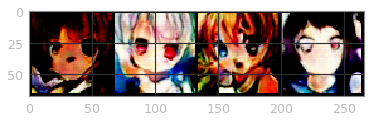

In [21]:
z = torch.randn(4, z_dimension).view(-1, z_dimension, 1, 1).to(device)
images = g(z)
# save_image(images, 'xx.png')

plt.imshow(Image.fromarray(make_grid(images).mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()))
plt.show()